The following notebook was used to cluster our 30 subreddits for each topic. Note that we used the sample code from the python package hlda (https://github.com/joewandy/hlda) as a model for our starting code.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

import pylab as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from ipywidgets import widgets
from IPython.core.display import HTML, display
from hlda.sampler import HierarchicalLDA
import string
import glob
import pandas as pd
import numpy as np

from textblob import TextBlob
import texttable as tt
from time import sleep

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import nltk.data
import os
import csv

# set your own working directory
directory = '../02-CleanedFiles/ShutdownWordBanks/*.txt'
topic_name = 'Shutdown'

/Users/laurenskorb/miniconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


After loading the necessary packages, we add a few words to our bag of valid words:

In [2]:
stopset = stopwords.words('english') + list(string.punctuation) + ['will', 'also', 'said']

Then, we loop through all of the text files for subreddits within a topic. We will run our clustering analyses separately for all of the 5 topics. (So we run this notebook separately for each topic)

In [3]:
corpus = []
all_docs = []
vocab = set()
names = []

stemmer = PorterStemmer()
for filename in glob.glob(directory):
    file_temp = str.split(filename,"/")[3]
    names.append(str.split(file_temp,"_")[0])
    with open(filename) as f:
        try:
            
            doc = f.read().splitlines() 
            doc = filter(None, doc) # remove empty string
            doc = '. '.join(doc)
            doc = doc.translate(str.maketrans('','',string.punctuation))
            doc = doc.translate(str.maketrans('','','1234567890')) # strip numbers        
            doc = doc.encode('ascii', 'ignore') # ignore fancy unicode chars
            all_docs.append(doc)        

            tokens = word_tokenize(str(doc))
            filtered = []
            for w in tokens:
                w = stemmer.stem(w.lower()) # use Porter's stemmer
                if len(w) < 3:              # remove short tokens
                    continue
                if w in stopset:            # remove stop words
                    continue
                filtered.append(w)
                
            vocab.update(filtered)
            corpus.append(filtered)      
            
        except UnicodeDecodeError:
            print('Failed to load', filename)


Once all the text files are loaded in, we get a set of all the vocab used for discussions on this topic:

In [4]:
vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i

Then, we want to make sure that we are getting 30 subreddits for each topic. This is an important check to make sure that we are clustering with all subreddits.

In [5]:
print(len(all_docs))
#print(corpus[0])

2


Then, we look at the vocab for this topic (across all 30 subreddits):

In [6]:
print(len(vocab))
#print(vocab[0:100])

981


Then, we want to create wordclouds for all of the comments/submissions related to this topic within each subreddit. We then save these wordclouds for each subreddit:

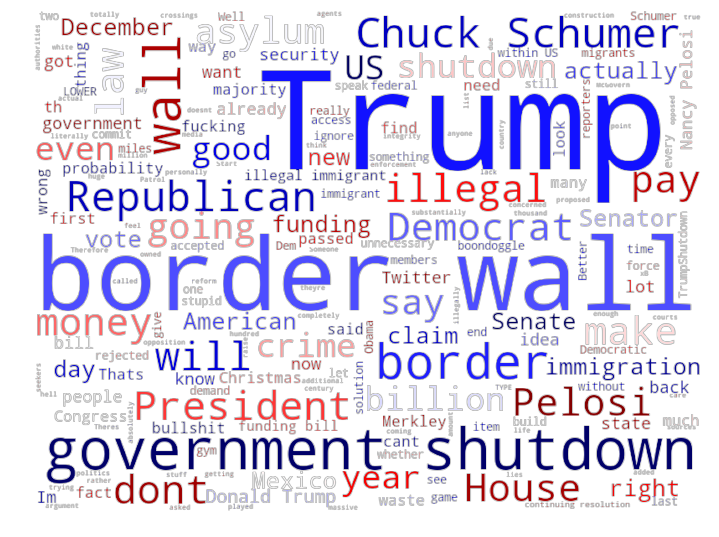

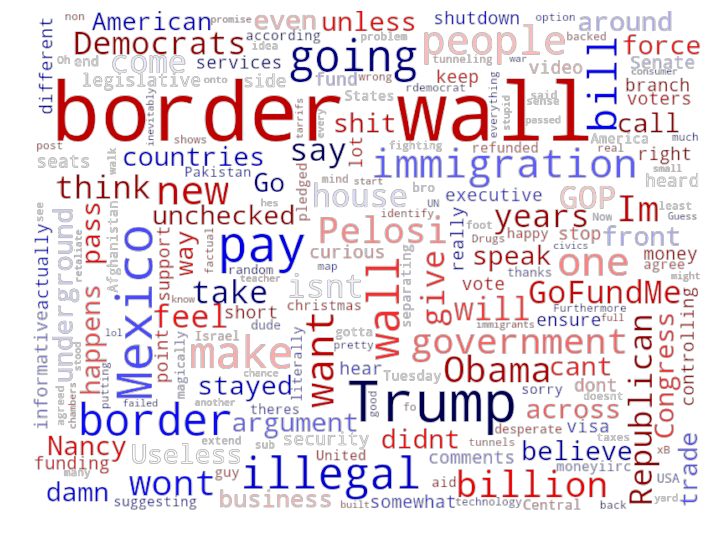

In [7]:
wordcloud_directory = '../04-VisualizationCode/WordCloud/Shutdown/'
for i,d in enumerate(all_docs):
    try:
        wordcloud = WordCloud(mode= "RGBA", background_color="rgba(255, 255, 255, 0)", colormap='seismic', width = 800, height=600).generate(d.decode("utf-8"))
        plt.figure(figsize=(12, 12))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        #plt.show()
        wordcloud.to_file(wordcloud_directory+str(names[i])+'.png') 
    except ValueError:
        print('No words', i)

I want to now check again the lengths of vocab, corpus, etc:

In [8]:
print(len(vocab), len(corpus), len(corpus[0]))

981 2 1706


We then clean up the documents with indexes in order to do our analyses:

In [9]:
new_corpus = []
for doc in corpus:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    if len(new_doc) == 0:
        new_corpus.append(new_doc)
    else:
        if len(new_doc)<10000:
            n = len(new_doc)
        else:
            n = 10000
        #print(n)
        new_doc = np.random.choice(new_doc,n,replace=True).tolist()
        new_corpus.append(new_doc)

In [10]:
print (len(vocab), len(new_corpus))
print (corpus[0][0:10])
print (new_corpus[0][0:10])

981 2
["b'that", 'blatantli', 'wrong', 'transcript', 'pelosi', 'dont', 'vote', 'border', 'wall', 'trump']
[474, 976, 556, 607, 91, 457, 316, 749, 247, 356]


IMPORTANT: This is where change the model parameters, and this is what we will change in order to compare different models!

In [11]:
n_samples = 500       # no of iterations for the sampler
alpha = 10.0          # smoothing over level distributions
gamma = 1.0           # CRP smoothing parameter; number of imaginary customers at next, as yet unused table
eta = 0.7            # smoothing over topic-word distributions
num_levels = 3        # the number of levels in the tree
display_topics = 50   # the number of iterations between printing a brief summary of the topics so far
n_words = 5           # the number of most probable words to print for each topic after model estimation
with_weights = False  # whether to print the words with the weights

We then run the hLDA:

In [12]:
hlda = HierarchicalLDA(new_corpus, vocab, alpha=alpha, gamma=gamma, eta=eta, num_levels=num_levels)
hlda.estimate(n_samples, display_topics=display_topics, n_words=n_words, with_weights=with_weights)

HierarchicalLDA sampling
.................................................. 50
topic 0 (level=0, total_words=1416, documents=2): border, wall, trump, shutdown, govern, 
    topic 1 (level=1, total_words=730, documents=2): border, wall, immigr, thi, one, 
        topic 2 (level=2, total_words=171, documents=2): gain, secur, take, question, say, 
.................................................. 100
topic 0 (level=0, total_words=1476, documents=2): wall, border, trump, shutdown, govern, 
    topic 1 (level=1, total_words=656, documents=2): border, wall, immigr, thi, one, 
        topic 2 (level=2, total_words=185, documents=2): billion, schumer, last, fact, point, 
.................................................. 150
topic 0 (level=0, total_words=1470, documents=2): border, wall, trump, shutdown, govern, 
    topic 1 (level=1, total_words=655, documents=2): border, wall, immigr, thi, say, 
        topic 2 (level=2, total_words=192, documents=2): misl, fenc, befor, person, migrant, 
..

Then we pull out the information that we want from this  model and save the clustering into a csv:

In [13]:
# prints top words in different topics
hlda.print_nodes( 10, with_weights)
# save leaves
reddit_leaves = hlda.document_leaves
reddit_leaves_df = pd.DataFrame.from_dict(reddit_leaves, orient='index')

topic 0 (level=0, total_words=1509, documents=2): border, wall, trump, shutdown, govern, pelosi, would, schumer, democrat, dont, 
    topic 1 (level=1, total_words=709, documents=2): border, wall, immigr, thi, trump, make, one, peopl, secur, say, 
        topic 2 (level=2, total_words=99, documents=2): mexico, stupid, valid, fact, feel, way, polit, onc, abandon, demand, 


In [14]:
#reddit_leaves_df['subreddit_id'] = reddit_leaves_df.index
reddit_leaves_df['topic_name'] = topic_name
reddit_leaves_df['subreddit_name'] = names
reddit_leaves_df.columns = ['values', 'subreddit_id','subreddit_name']
reddit_leaves_df['values'] = reddit_leaves_df['values'].astype(str)
temp = reddit_leaves_df['values'].str.split(' ', 4, expand=True)
temp.columns = ['cluster', 'level','customers','total_words','cluster_family']
reddit_leaves_df['cluster']=temp['cluster'].str.replace('^[^\d]*', '')
reddit_leaves_df['level']=temp['level'].str.replace('^[^\d]*', '')
reddit_leaves_df['customers']=temp['customers'].str.replace('^[^\d]*', '')
reddit_leaves_df['total_words']=temp['total_words'].str.replace('^[^\d]*', '')
reddit_leaves_df['cluster_family']=temp['cluster_family'].str.replace('^[^\d]*', '')
reddit_leaves_df=reddit_leaves_df.drop(columns=['values'])
#reddit_leaves_df.to_csv("parkland_output_2.0.csv",index=False)

In [15]:
display(reddit_leaves_df)

,subreddit_id,subreddit_name,cluster,level,customers,total_words,cluster_family
0,Shutdown,democrats,2,2,2,99,1
1,Shutdown,Republican,2,2,2,99,1


## TextGlob subjectivity analyses:

In [16]:
search_results_list = []
subjectivity_list = []
polarity_list = []
num = []
for doc in all_docs:
    d = doc.decode(encoding='utf-8', errors='strict')
    analysis = TextBlob(d)
    subjectivity = analysis.sentiment.subjectivity
    subjectivity_list.append(subjectivity)
    polarity = analysis.sentiment.polarity
    polarity_list.append(polarity)
    #number = number + 1
    #num.append(number)
    sleep(5)

In [17]:
political_bias = {'subreddit':names,'subjectivity':subjectivity_list,'polarity':polarity_list}
political_bias_df = pd.DataFrame.from_dict(political_bias)
political_bias_df['topic_name'] = topic_name

In [18]:
display(political_bias_df)

,subreddit,subjectivity,polarity,topic_name
0,democrats,0.459810,0.053798,Shutdown
1,Republican,0.515685,0.026334,Shutdown


## NLTK sentiment analyses:

In [19]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
avg_pos_list = []
avg_neg_list = []
avg_neu_list = []
avg_compound_list = []

for filename in glob.glob(directory):
    #file_temp = str.split(filename,"/")[4]
    #names.append(str.split(file_temp,"_")[2])
    with open(filename) as f:
        file_input= f.read()
        sentences=(tokenizer.tokenize(file_input))
        avg_compound=0*1.0
        avg_neg=0*1.0
        avg_neu=0*1.0
        avg_pos=0*1.0
        sid = SentimentIntensityAnalyzer()

        for sentence in sentences:
            #print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                #print('{0}: {1}, '.format(k, ss[k]), end='')
                #print(k,ss[k])
                if k is "compound":
                    avg_compound=avg_compound+ss[k]
                elif k is "neg":
                    avg_neg=avg_neg+ss[k]
                elif k is "neu":
                    avg_neu=avg_neu+ss[k]
                elif k is "pos":
                    avg_pos=avg_pos+ss[k]

        if len(sentences)!= 0:
            avg_neg = avg_neg/len(sentences)
            avg_pos = avg_pos/len(sentences)
            avg_neu = avg_neu/len(sentences)
            avg_compound = avg_compound/len(sentences)

    avg_pos_list.append(avg_pos)
    avg_neu_list.append(avg_pos)
    avg_neg_list.append(avg_pos)
    avg_compound_list.append(avg_compound)

In [20]:
sentiment = {'subreddit_name':names,'avg_neg':avg_neg_list,'avg_pos': avg_pos_list,'avg_neu':avg_neu_list,'avg_compound':avg_compound_list}
sentiment_df = pd.DataFrame.from_dict(sentiment)
sentiment_df['topic_name'] = topic_name

In [21]:
display(sentiment_df)

,subreddit_name,avg_neg,avg_pos,avg_neu,avg_compound,topic_name
0,democrats,0.078226,0.078226,0.078226,-0.097205,Shutdown
1,Republican,0.089529,0.089529,0.089529,-0.000477,Shutdown


## Read in meta data about subreddits

In [22]:
with open('../02-CleanedFiles/RC_2018_12_counts.csv', mode='r') as infile:
    reader = csv.reader(infile)
    submission_count = {rows[0]:rows[1] for rows in reader}
tot_submissions = [submission_count[name] for name in names]

In [23]:
with open('../02-CleanedFiles/RC_2018_12_counts.csv', mode='r') as infile:
    reader = csv.reader(infile)
    comments_count = {rows[0]:rows[1] for rows in reader}
tot_comments = [submission_count[name] for name in names]

In [24]:
with open('../01-DataCleaningCode/RedditMetaData/SubredditSubscribers.csv', mode='r') as infile:
    reader = csv.reader(infile)
    subscribers_count = {rows[0]:rows[1] for rows in reader}
subscribers_count_list = [subscribers_count[name] for name in names]

## Putting it all together!

In [25]:
#combine all together
combined = {'subreddit_name':names,'avg_neg':avg_neg_list,'avg_pos': avg_pos_list,'avg_neu':avg_neu_list,'avg_compound':avg_compound_list,'subscribers_count':subscribers_count_list,'comments_count':tot_comments,'submissions_count':tot_submissions,'subjectivity':subjectivity_list,'cluster':list(reddit_leaves_df.cluster),'cluster_family':list(reddit_leaves_df.cluster_family)}
combined_df = pd.DataFrame.from_dict(combined)
combined_df.insert(0, "topic_name", topic_name) 
display(combined_df)

,topic_name,subreddit_name,avg_neg,avg_pos,avg_neu,avg_compound,subscribers_count,comments_count,submissions_count,subjectivity,cluster,cluster_family
0,Shutdown,democrats,0.078226,0.078226,0.078226,-0.097205,56922,26,26,0.459810,2,1
1,Shutdown,Republican,0.089529,0.089529,0.089529,-0.000477,42843,16,16,0.515685,2,1


In [26]:
# save output for viz!
combined_df.to_csv("../04-VisualizationCode/data.csv",index=False)